In [1]:
import gym
import numpy as np
from offsim4rl.envs import gridworld
from offsim4rl.agents import spinup
import torch

No protocol specified


In [2]:
from offsim4rl.data import OfflineDataset, ProbDistribution
from offsim4rl.evaluators.per_state_rejection import PerStateRejectionSampling

In [3]:
class OracleEncoder(object):
    def __init__(self):
        pass
    def encode(self, observations):
        zs = []
        for x, y in observations:
            xx, yy = int(x*5), int(y*5)
            z = xx + 5*yy
            zs.append(z)
        return zs

In [4]:
from offsim4rl.utils.dataset_utils import load_h5_dataset
from offsim4rl.data import SAS_Dataset
from offsim4rl.encoders.homer import HOMEREncoder
from offsim4rl.utils.vis_utils import plot_latent_state_color_map
buffer = load_h5_dataset('../outputs/MyGridNaviCoords-v1_random.h5')

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 32.85it/s]


In [5]:
dataset = OfflineDataset(
    observation_space=gym.spaces.Box(low=0, high=1, shape=(2,)),
    action_space=gym.spaces.Discrete(5),
    action_dist_type=ProbDistribution.Discrete,
    observations=buffer['observations'],
    actions=buffer['actions'].astype(int),
    action_distributions=buffer['infos/probs'],
    rewards=buffer['rewards'],
    next_observations=buffer['next_observations'],
    terminals=buffer['terminals'].astype(bool),
    steps=buffer['infos/steps'].astype(int),
)

2022-08-17 20:32:47,358 - WARNING - root -  Missing episode_ids in experience. Some algorithms may not be compatible with this dataset.


In [6]:
psrs = PerStateRejectionSampling(
    dataset,
    num_states=25,
    encoder=OracleEncoder(),
)

## Learn

In [7]:
# true env for online validation
env = gym.make('MyGridNaviCoords-v1', seed=100000)
env.reset_task(np.array([4, 4]))

array([4, 4])

In [ ]:
for seed in range(10):
    spinup.ppo_revealed(
        env_fn=lambda: psrs, steps_per_epoch=5000, epochs=50, seed=seed, 
        logger_kwargs=dict(output_dir=f'./outputs/grid_psrs_oracle/seed={seed}', exp_name='MyGridNaviCoords-v1_ppo_test_psrs_oracle'), 
        ac_kwargs=dict(hidden_sizes=[32, 32], activation=torch.nn.ReLU), 
        validate=True, val_kwargs=dict(val_env_fn=lambda: env, val_n_episodes=10))

In [21]:
psrs.reset_sampler(seed=1)
seed = 10
spinup.ppo_revealed(
    env_fn=lambda: psrs, steps_per_epoch=5000, epochs=50, seed=seed, 
    logger_kwargs=dict(output_dir=f'./outputs/grid_psrs_oracle/seed={seed}', exp_name='MyGridNaviCoords-v1_ppo_test_psrs_oracle'), 
    ac_kwargs=dict(hidden_sizes=[32, 32], activation=torch.nn.ReLU), 
    validate=True, val_kwargs=dict(val_env_fn=lambda: env, val_n_episodes=10))

Logging data to ./outputs/grid_psrs_oracle/seed=10/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7fb53e927f80>",
    "epochs":	50,
    "exp_name":	"MyGridNaviCoords-v1_ppo_test_psrs_oracle",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<offsim4rl.agents.spinup.utils.logx.EpochLogger object at 0x7fb53eab64d0>":	{
            "epoch_dict":	{},
            "exp_name":	"MyGridNaviCoords-v1_ppo_test_psrs_oracle",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"./outputs/grid_psrs_oracle/seed=10",
            "output_file":	{
                "<_io.TextIOWrapper name='./outputs/grid_psrs_oracle/seed=10/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
  

AssertionError: 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv(f'./outputs/grid_psrs_oracle/seed={seed}/progress.txt', sep='\t')

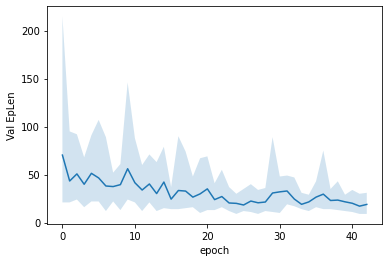

In [19]:
plt.plot(df['AverageVal_EpLen'])
plt.fill_between(df['Epoch'], df['MinVal_EpLen'], df['MaxVal_EpLen'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.show()

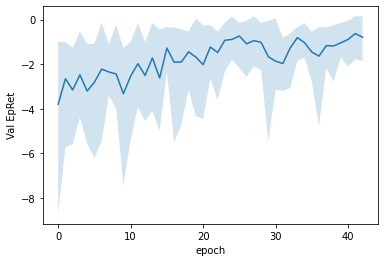

In [20]:
plt.plot(df['AverageVal_EpRet'])
plt.fill_between(df['Epoch'], df['MinVal_EpRet'], df['MaxVal_EpRet'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('Val EpRet')
plt.show()

In [ ]:
def test_per_state_rejection_discrete():
    dataset = OfflineDataset(
        observation_space=gym.spaces.Discrete(25),
        action_space=gym.spaces.Discrete(4),
        action_dist_type=ProbDistribution.Discrete,
        observations=np.array([0, 5], dtype=np.int64),
        actions=np.array([0, 1], dtype=np.int64),
        action_distributions=np.full((2, 4), fill_value=0.25, dtype=np.float32),
        rewards=np.array([0.0, 1.0], dtype=np.float32),
        next_observations=np.array([5, 7], dtype=np.int64),
        terminals=np.array([False, True], dtype=bool))
    psrs = PerStateRejectionSampling(dataset)
    obs = psrs.reset()
    assert obs.shape == tuple()
    psrs.step_dist(get_uniform_dist(dataset.action_space))

In [1]:
import sys
sys.path.append('../../src')

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import HOMER.data
buffer = HOMER.data.load_h5_dataset('../../data/grid/MyGridNaviCoords-v1_random.hdf')

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.16it/s]


In [4]:
buffer.keys()

dict_keys(['actions', 'infos/probs', 'infos/timesteps', 'next_observations', 'observations', 'rewards', 'terminals'])

In [5]:
buffer_ = [(
    buffer['observations'][i],
    buffer['actions'][i],
    buffer['rewards'][i],
    buffer['next_observations'][i],
    buffer['terminals'][i],
    buffer['infos/probs'][i],
    {'t': buffer['infos/timesteps'][i]},
) for i in range(len(buffer['observations']))]

In [6]:
buffer_[0]

(array([0.04276233, 0.12755609], dtype=float32),
 3,
 -0.1,
 array([0.18468815, 0.01150152], dtype=float32),
 False,
 array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
 {'t': 0.0})

In [7]:
from HOMER.model import EncoderModel
encoding_function = EncoderModel(2, 5, 50, 64).to(device)
encoding_function.load('./HOMER/output/trial=20220727T1748,encoder_model=both,seed=0,dZ=50,dH=64,lr=0.001,weight_decay=0.0/', 'encoder_model.pt')

import torch.nn.functional as F
def encode_observations(model, observations):
    assert len(observations.size()) == 1
    observations = observations.view(1, -1)
    log_prob = F.log_softmax(model.obs_encoder(observations), dim=1)
    argmax_indices = log_prob.max(1)[1]
    return int(argmax_indices[0])

In [8]:
import simulate.lib_psrs
import gym

In [9]:
env_psrs = simulate.lib_psrs.gymPSRS(
    buffer_,
    observation_space=gym.spaces.Box(low=0, high=1, shape=(2,)), 
    action_space=gym.spaces.Discrete(5), 
    latent_state_func=lambda s: encode_observations(encoding_function, torch.tensor(s).to(device))
)

In [10]:
env_psrs.reset_sampler(seed=0)

In [11]:
env_psrs.buffer

[(44,
  array([0.04276233, 0.12755609], dtype=float32),
  3,
  -0.1,
  array([0.18468815, 0.01150152], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 0.0}),
 (44,
  array([0.18468815, 0.01150152], dtype=float32),
  1,
  -0.1,
  array([0.13923521, 0.2853215 ], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 1.0}),
 (15,
  array([0.13923521, 0.2853215 ], dtype=float32),
  0,
  -0.1,
  array([0.0665991 , 0.33859718], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 2.0}),
 (15,
  array([0.0665991 , 0.33859718], dtype=float32),
  0,
  -0.1,
  array([0.11653665, 0.23789696], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 3.0}),
 (15,
  array([0.11653665, 0.23789696], dtype=float32),
  4,
  -0.1,
  array([0.05105221, 0.21079233], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 4.0}),
 (15,
  array([0.05105221, 0.2

In [13]:
import spinup
env_fn = lambda: env_psrs
ac_kwargs = dict(hidden_sizes=[32,32], activation=torch.nn.ReLU)
logger_kwargs = dict(output_dir='../../data/grid/psrs3', exp_name='MyGridNaviCoords-v1_ppo_test_psrs3')

In [14]:
spinup.algos.pytorch.ppo_revealed.ppo.ppo(env_fn=env_fn, ac_kwargs=ac_kwargs, steps_per_epoch=5000, epochs=50, logger_kwargs=logger_kwargs)

Logging data to ../../data/grid/psrs3/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7ff3e5c144c0>",
    "epochs":	50,
    "exp_name":	"MyGridNaviCoords-v1_ppo_test_psrs3",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7ff34f597dc0>":	{
            "epoch_dict":	{},
            "exp_name":	"MyGridNaviCoords-v1_ppo_test_psrs3",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"../../data/grid/psrs3",
            "output_file":	{
                "<_io.TextIOWrapper name='../../data/grid/psrs3/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_nam

In [ ]:
import importlib
importlib.reload(simulate.lib_psrs)
importlib.reload(spinup)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('../../data/grid/psrs3/progress.txt', sep='\t')

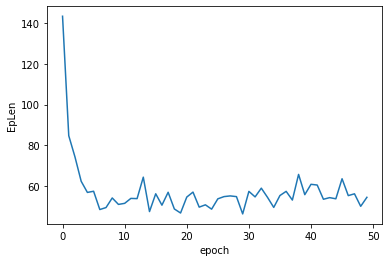

In [17]:
plt.plot(df['EpLen'])
plt.xlabel('epoch')
plt.ylabel('EpLen')
plt.show()

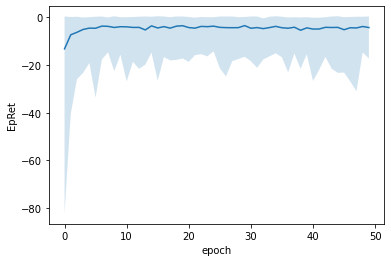

In [18]:
plt.plot(df['AverageEpRet'])
plt.fill_between(df['Epoch'], df['MinEpRet'], df['MaxEpRet'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('EpRet')
plt.show()

In [19]:
from spinup.utils.test_policy import load_policy_and_env, run_policy
_, get_action = load_policy_and_env('../../data/grid/psrs3')



Loading from ../../data/grid/psrs3/pyt_save/model.pt.




In [20]:
from gym.envs.registration import register

register(
    'MyGridNaviCoords-v1',
    entry_point='gridworld:MyGridNaviCoords',
    kwargs={'num_cells': 5, 'num_steps': 1000},
)

In [21]:
import gym
import numpy as np

env = gym.make('MyGridNaviCoords-v1')
env.reset_task(np.array([4,4]))
env_fn = lambda: env

In [22]:
run_policy(env, lambda x: int(get_action(x).sample()), render=False, num_episodes=10)

Logging data to /tmp/experiments/1659970961/progress.txt
Episode 0 	 EpRet -2.400 	 EpLen 35
Episode 1 	 EpRet -2.700 	 EpLen 38
Episode 2 	 EpRet -3.200 	 EpLen 43
Episode 3 	 EpRet -0.400 	 EpLen 15
Episode 4 	 EpRet -14.100 	 EpLen 152
Episode 5 	 EpRet -1.600 	 EpLen 27
Episode 6 	 EpRet -0.700 	 EpLen 18
Episode 7 	 EpRet -7.100 	 EpLen 82
Episode 8 	 EpRet -2.800 	 EpLen 39
Episode 9 	 EpRet -3.500 	 EpLen 46
-------------------------------------
|    AverageEpRet |           -3.85 |
|        StdEpRet |            3.84 |
|        MaxEpRet |            -0.4 |
|        MinEpRet |           -14.1 |
|           EpLen |            49.5 |
-------------------------------------
